# Part 1 — Load data and define the SurveyEncoder (run first)

In [22]:
# Part 1: Load DB, drop columns, and define SurveyEncoder
import mysql.connector
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelBinarizer
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import joblib


# Connect
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="shalongo",
    database="AI_HAIR_ASSIST"
)

# Load full table into DataFrame
df = pd.read_sql("SELECT * FROM hairsurvey", conn)

# Close connection
conn.close()

df = df.iloc[:132].reset_index(drop=True)


#df.columns

# Drop irrelevant columns (e.g., email, survey codes, etc.)
columns_to_drop = [
 'Timestamp', 'Score', 'Email', 'Email_address', 'survey_id', 'user_id',
 "SurveyCircle \n 'Thank-you-for-your-participation' page. Please use the following text line that contains your Survey Code:",
 'Column 53', 'Would_you_participate_in_followup_studies'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

#df.columns



class SurveyEncoder:
    def __init__(self, numeric_columns, ordinal_columns, nominal_columns, binary_columns):
        self.numeric_columns = numeric_columns
        self.ordinal_columns = ordinal_columns
        self.nominal_columns = nominal_columns
        self.binary_columns = binary_columns

        self.scaler = StandardScaler()
        self.ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        self.nominal_encoders = {}
        self.feature_columns_ = None
        self.fitted = False

    # --- helper for label binarizer ---
    def _fit_label_binarizer(self, series, col):
        """Fit LabelBinarizer and store encoder"""
        series = series.astype(str).str.lower().str.strip()
        lb = LabelBinarizer()
        lb.fit(series)
        self.nominal_encoders[col] = lb

    def _transform_label_binarizer(self, series, col):
        """Transform series using already fitted LabelBinarizer"""
        lb = self.nominal_encoders[col]
        series = series.astype(str).str.lower().str.strip()
        # unseen categories → mark as zero vector
        known_classes = set(lb.classes_)
        mask_unknown = ~series.isin(known_classes)
        series[mask_unknown] = lb.classes_[0]  # fallback to first known class
        arr = lb.transform(series)
        if arr.ndim == 1:
            arr = arr.reshape(-1, 1)
        # consistent column names
        if len(lb.classes_) == 2:
            col_names = [f"{col}_{lb.classes_[1]}"]
        else:
            col_names = [f"{col}_{cls}" for cls in lb.classes_]
        df_enc = pd.DataFrame(arr, columns=col_names, index=series.index)
        return df_enc

    # --- fitting ---
    def fit(self, df):
        # Fit numeric scaler
        self.scaler.fit(df[self.numeric_columns])
        # Fit ordinal encoder
        self.ordinal_encoder.fit(df[self.ordinal_columns])
        # Fit label binarizers for col in self.nominal_columns + self.binary_columns:
        for col in self.nominal_columns + self.binary_columns:
            self._fit_label_binarizer(df[col], col)
        # Create feature column order for reference
        X_encoded = self._transform_internal(df)
        self.feature_columns_ = X_encoded.columns.tolist()
        self.fitted = True
        return self

    # --- internal transform (no column reindex) ---
    def _transform_internal(self, df):
        parts = []
        # Numeric
        num_scaled = self.scaler.transform(df[self.numeric_columns])
        parts.append(pd.DataFrame(num_scaled, columns=self.numeric_columns, index=df.index))
        # Ordinal
        ord_enc = self.ordinal_encoder.transform(df[self.ordinal_columns])
        parts.append(pd.DataFrame(ord_enc, columns=self.ordinal_columns, index=df.index))
        # Nominal + Binary
        for col in self.nominal_columns + self.binary_columns:
            df_enc = self._transform_label_binarizer(df[col], col)
            parts.append(df_enc)
        encoded_df = pd.concat(parts, axis=1)
        return encoded_df

    # --- public transform ---
    def transform(self, df):
        if not self.fitted:
            raise ValueError("Encoder must be fitted before transform.")
        encoded_df = self._transform_internal(df)
        # Ensure same columns and order as training
        encoded_df = encoded_df.reindex(columns=self.feature_columns_, fill_value=0)
        return encoded_df

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

    # --- save/load helpers ---
    def save(self, path):
        """Save encoder to disk."""
        joblib.dump(self, path)

    @staticmethod
    def load(path):
        """Load encoder from disk."""
        return joblib.load(path)


# Part 2: Define columns, fit encoder, save encoder, reload and transform a single row

# Define columns to encode,
numeric_columns = ['Consumed_water_per_day_L']
ordinal_columns = [
    'Current_Hair_condition', 'Age', 'Hair_porosity', 'Hair_texture', 'Hair_density',
    'Harline_condition', 'Hair_Breakage', 'Hair_Loss_state',
    'Hair_length_Current_Hair_Length', 'Hair_length_Hair_goal', 'Country',
    'Hair_type', 'How_often_do_you_Heatstyling_tools', 'How_often_do_you_Tight_hairstyle',
    'How_often_do_you_Hair_moisturizer', 'How_often_do_you_Scalp_massages',
    'How_often_do_you_Hair_Wash', 'Occurrence_of_hair_breakage', 'Causes_of_hair_breakage'
]
nominal_columns = [
    'Race', 'Gender', 'Hair_edges_condition', 'Hair_look', 'Scalp_condition',
    'Is_your_hair_chemically_treated', 'Professional_treatments', 'Protective_hairstyles_No_1',
    'Protective_hairstyles_No_2', 'Condition_of_protective_hairstyles_used',
    'Protective_hairstyles_maintenance', 'Causes_of_hair_breakage', 'Comb_type',
    'Detangling_style', 'Eating_diet', 'Hair_state_and_their_cause_Hydrated__Healthy',
    'Hair_state_and_their_cause_Promote_Frizzy', 'Hair_state_and_their_cause_Tangled',
    'Hair_state_and_their_cause_dryness__breaking'
]
sentence_columns = [
    'Ingredient_promotes_your_hair_health', 'Other_please_specify', 'Hair_Supplement_used',
    'medication_or_Condition_affecting_Hair_growth', 'Hair_or_scalp_allergies',
    'Tips_or_products_have_worked_well_for_your_hair', 'Main_factor_influencing_your_hair_health_or_growth'
]
binary_columns = [
    'Keratin_Treatment', 'Family_history_of_hair_loss_or_slow_growth', 'Satin_scarfbonnet_or_pillowcase'
]

# Convert numeric column to float
df['Consumed_water_per_day_L'] = pd.to_numeric(df['Consumed_water_per_day_L'], errors='coerce')
df['Consumed_water_per_day_L'] = df['Consumed_water_per_day_L'].fillna(0)


# initialize
encoder = SurveyEncoder(numeric_columns, ordinal_columns, nominal_columns, binary_columns)

# fit on training data
df_final = encoder.fit_transform(df)
print("Final encoded dataset shape:", df_final.shape)

# save encoder
encoder.save("survey_encoder.pkl")
print("Saved encoder to survey_encoder.pkl")

# later... demonstrate loading encoder
encoder = SurveyEncoder.load("survey_encoder.pkl")
print("Reloaded encoder from survey_encoder.pkl")

# transform a single new row (still produces same encoded columns order)
encoded_row = encoder.transform(df.head(1))
print("Encoded single row shape:", encoded_row.shape)




# Part 3: Label target, train model, save model, reload model, predict on one encoded row and print prediction


# === Check for NaNs ===
if df_final.isnull().values.any():
    print("⚠️ Found missing values — filling with 0")
    df_final = df_final.fillna(0)

# === Step 3: Features and Target ===
# Note: df_final is encoded full dataset
# We drop the target column for X
X = df_final.drop(columns=['Current_Hair_condition'])

# === Label encode string targets like "Dry", "Healthy", etc. ===
label_enc = LabelEncoder()
dfx = df.copy(deep=True)
dfx['Current_Hair_condition'] = label_enc.fit_transform(dfx['Current_Hair_condition'])

if dfx.isnull().values.any():
    dfx = dfx.fillna(0)

# === Then do one-hot encoding ===
y = df_final['Current_Hair_condition']
y_cat = to_categorical(y)

# === Save class names for decoding later ===
class_names = label_enc.classes_
print("Class names for target (label encoder classes):", class_names)

# Save the label encoder to disk for later decoding
joblib.dump(label_enc, "label_encoder.pkl")
print("Saved label encoder to label_encoder.pkl")

# === Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

#save the dnn features
joblib.dump(list(X_train.columns), "dnn_feature_columns.pkl")
print("Saved DNN feature columns")

# === Build Model ===
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Step 7: Add EarlyStopping to monitor val_accuracy ===
from tensorflow.keras.callbacks import Callback
class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold=00.6471):
        super().__init__()
        self.threshold = threshold
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc > self.threshold:
            print(f"\n✅ Reached {val_acc:.2f} validation accuracy. Stopping training.")
            self.model.stop_training = True

acc_threshold = AccuracyThresholdCallback(threshold=0.75)

# === Step 8: Train the model ===
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[acc_threshold],
    verbose=1
)

model.save("DNN_hair_Health_classifier_v1.h5")
print("Saved model to DNN_hair_Health_classifier_v1.h5")

# === Now: reload saved model and perform prediction on one row ===
from tensorflow.keras.models import load_model
loaded_model = load_model("DNN_hair_Health_classifier_v1.h5")
print("Reloaded model from DNN_hair_Health_classifier_v1.h5")

# reload encoder and label encoder
enc_loaded = SurveyEncoder.load("survey_encoder.pkl")
print("Reloaded encoder from survey_encoder.pkl")
label_enc_loaded = joblib.load("label_encoder.pkl")
print("Reloaded label encoder from label_encoder.pkl")

# prepare a single row for prediction:
single_row_raw = df.head(10)  # using the same first row
encoded_single = enc_loaded.transform(single_row_raw)
print("Encoded single row shape (with target col possibly included):", encoded_single.shape)

# The model was trained on X which is df_final with Current_Hair_condition dropped.
# So drop target column if present in encoded_single, then reindex columns to match X_train
encoded_for_pred = encoded_single.drop(columns=['Current_Hair_condition'], errors='ignore')
encoded_for_pred = encoded_for_pred.reindex(columns=X_train.columns, fill_value=0)
print("Encoded single row shape after dropping target and reindexing:", encoded_for_pred.shape)

# Make prediction
pred_probs = loaded_model.predict(encoded_for_pred)
pred_index = np.argmax(pred_probs, axis=1)[0]
pred_class_label = label_enc_loaded.inverse_transform([pred_index])[0]

print("Prediction probabilities for the single row:", pred_probs)
print("Predicted class index:", pred_index)
print("Predicted class label (decoded):", pred_class_label)





/var/folders/sd/2tmrf4ds7nqg7lk_wdy856vm0000gn/T/ipykernel_44311/769644017.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM hairsurvey", conn)


# Part 2 — Fit the encoder, save & reload encoder, and produce encoded dataset (run second)

In [27]:
# Part 2: Define columns, fit encoder, save encoder, reload and transform a single row

# Define columns to encode,
numeric_columns = ['Consumed_water_per_day_L']
ordinal_columns = [
    'Current_Hair_condition', 'Age', 'Hair_porosity', 'Hair_texture', 'Hair_density',
    'Harline_condition', 'Hair_Breakage', 'Hair_Loss_state',
    'Hair_length_Current_Hair_Length', 'Hair_length_Hair_goal', 'Country',
    'Hair_type', 'How_often_do_you_Heatstyling_tools', 'How_often_do_you_Tight_hairstyle',
    'How_often_do_you_Hair_moisturizer', 'How_often_do_you_Scalp_massages',
    'How_often_do_you_Hair_Wash', 'Occurrence_of_hair_breakage', 'Causes_of_hair_breakage'
]
nominal_columns = [
    'Race', 'Gender', 'Hair_edges_condition', 'Hair_look', 'Scalp_condition',
    'Is_your_hair_chemically_treated', 'Professional_treatments', 'Protective_hairstyles_No_1',
    'Protective_hairstyles_No_2', 'Condition_of_protective_hairstyles_used',
    'Protective_hairstyles_maintenance', 'Causes_of_hair_breakage', 'Comb_type',
    'Detangling_style', 'Eating_diet', 'Hair_state_and_their_cause_Hydrated__Healthy',
    'Hair_state_and_their_cause_Promote_Frizzy', 'Hair_state_and_their_cause_Tangled',
    'Hair_state_and_their_cause_dryness__breaking'
]
sentence_columns = [
    'Ingredient_promotes_your_hair_health', 'Other_please_specify', 'Hair_Supplement_used',
    'medication_or_Condition_affecting_Hair_growth', 'Hair_or_scalp_allergies',
    'Tips_or_products_have_worked_well_for_your_hair', 'Main_factor_influencing_your_hair_health_or_growth'
]
binary_columns = [
    'Keratin_Treatment', 'Family_history_of_hair_loss_or_slow_growth', 'Satin_scarfbonnet_or_pillowcase'
]

# Convert numeric column to float
df['Consumed_water_per_day_L'] = pd.to_numeric(df['Consumed_water_per_day_L'], errors='coerce')
df['Consumed_water_per_day_L'] = df['Consumed_water_per_day_L'].fillna(0)


# initialize
encoder = SurveyEncoder(numeric_columns, ordinal_columns, nominal_columns, binary_columns)

# fit on training data
df_final = encoder.fit_transform(df)
print("Final encoded dataset shape:", df_final.shape)

# save encoder
encoder.save("survey_encoder.pkl")
print("Saved encoder to survey_encoder.pkl")

# later... demonstrate loading encoder
encoder = SurveyEncoder.load("survey_encoder.pkl")
print("Reloaded encoder from survey_encoder.pkl")

# transform a single new row (still produces same encoded columns order)
encoded_row = encoder.transform(df.head(1))
print("Encoded single row shape:", encoded_row.shape)




Final encoded dataset shape: (132, 176)
Saved encoder to survey_encoder.pkl
Reloaded encoder from survey_encoder.pkl
Encoded single row shape: (1, 176)


# Part 3 — Label encoding, training the DNN, save & reload the model, predict on one row (run last)

In [37]:
# Part 3: Label target, train model, save model, reload model, predict on one encoded row and print prediction


# === Check for NaNs ===
if df_final.isnull().values.any():
    print("⚠️ Found missing values — filling with 0")
    df_final = df_final.fillna(0)

# === Step 3: Features and Target ===
# Note: df_final is encoded full dataset
# We drop the target column for X
X = df_final.drop(columns=['Current_Hair_condition'])

# === Label encode string targets like "Dry", "Healthy", etc. ===
label_enc = LabelEncoder()
dfx = df.copy(deep=True)
dfx['Current_Hair_condition'] = label_enc.fit_transform(dfx['Current_Hair_condition'])

if dfx.isnull().values.any():
    dfx = dfx.fillna(0)

# === Then do one-hot encoding ===
y = df_final['Current_Hair_condition']
y_cat = to_categorical(y)

# === Save class names for decoding later ===
class_names = label_enc.classes_
print("Class names for target (label encoder classes):", class_names)

# Save the label encoder to disk for later decoding
joblib.dump(label_enc, "label_encoder.pkl")
print("Saved label encoder to label_encoder.pkl")

# === Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

#save the dnn features
joblib.dump(list(X_train.columns), "dnn_feature_columns.pkl")
print("Saved DNN feature columns")

# === Build Model ===
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Step 7: Add EarlyStopping to monitor val_accuracy ===
from tensorflow.keras.callbacks import Callback
class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold=00.6471):
        super().__init__()
        self.threshold = threshold
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc > self.threshold:
            print(f"\n✅ Reached {val_acc:.2f} validation accuracy. Stopping training.")
            self.model.stop_training = True

acc_threshold = AccuracyThresholdCallback(threshold=0.75)

# === Step 8: Train the model ===
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[acc_threshold],
    verbose=1
)

model.save("DNN_hair_Health_classifier_v1.h5")
print("Saved model to DNN_hair_Health_classifier_v1.h5")

# === Now: reload saved model and perform prediction on one row ===
from tensorflow.keras.models import load_model
loaded_model = load_model("DNN_hair_Health_classifier_v1.h5")
print("Reloaded model from DNN_hair_Health_classifier_v1.h5")

# reload encoder and label encoder
enc_loaded = SurveyEncoder.load("survey_encoder.pkl")
print("Reloaded encoder from survey_encoder.pkl")
label_enc_loaded = joblib.load("label_encoder.pkl")
print("Reloaded label encoder from label_encoder.pkl")

# prepare a single row for prediction:
single_row_raw = df.head(10)  # using the same first row
encoded_single = enc_loaded.transform(single_row_raw)
print("Encoded single row shape (with target col possibly included):", encoded_single.shape)

# The model was trained on X which is df_final with Current_Hair_condition dropped.
# So drop target column if present in encoded_single, then reindex columns to match X_train
encoded_for_pred = encoded_single.drop(columns=['Current_Hair_condition'], errors='ignore')
encoded_for_pred = encoded_for_pred.reindex(columns=X_train.columns, fill_value=0)
print("Encoded single row shape after dropping target and reindexing:", encoded_for_pred.shape)

# Make prediction
pred_probs = loaded_model.predict(encoded_for_pred)
pred_index = np.argmax(pred_probs, axis=1)[0]
pred_class_label = label_enc_loaded.inverse_transform([pred_index])[0]

print("Prediction probabilities for the single row:", pred_probs)
print("Predicted class index:", pred_index)
print("Predicted class label (decoded):", pred_class_label)




Class names for target (label encoder classes): ['' 'Damaged' 'Dry' 'Healthy' 'Moisturize']
Saved label encoder to label_encoder.pkl
Saved DNN feature columns
Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.2972 - loss: 4.0803 - val_accuracy: 0.3810 - val_loss: 4.2631
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3663 - loss: 4.6041 - val_accuracy: 0.2381 - val_loss: 3.6506
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3504 - loss: 3.1476 - val_accuracy: 0.3810 - val_loss: 1.4174
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3170 - loss: 3.2912 - val_accuracy: 0.4286 - val_loss: 1.2787
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4585 - loss: 2.6610 - val_accuracy: 0.3333 - val_loss: 2.0707
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3958 - loss: 2.9657 - val_accuracy: 0.3333 - val_loss: 2.2102
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4113 - loss: 2.7028 

Saved model to DNN_hair_Health_classifier_v1.h5
Reloaded model from DNN_hair_Health_classifier_v1.h5
Reloaded encoder from survey_encoder.pkl
Reloaded label encoder from label_encoder.pkl
Encoded single row shape (with target col possibly included): (10, 176)
Encoded single row shape after dropping target and reindexing: (10, 175)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction probabilities for the single row: [[1.4082931e-19 2.3554045e-37 2.3217926e-28 1.0000000e+00 4.3614203e-29]
 [9.9893574e-13 5.4008599e-14 2.4970042e-09 1.0000000e+00 1.5968338e-12]
 [3.1779849e-20 1.5652782e-21 2.5575492e-21 1.0000000e+00 3.7376860e-10]
 [1.1756160e-12 5.3301368e-17 1.0000000e+00 2.2931145e-21 9.6843805e-17]
 [4.1155422e-23 9.9999893e-01 1.6209242e-08 1.6434740e-14 1.1100129e-06]
 [4.2663918e-11 6.4603474e-12 2.3819130e-05 9.9997616e-01 1.9570949e-09]
 [2.6449673e-10 3.2255691e-20 1.0000000e+00 3.8645293e-17 1.3762838e-27]
 [7.5089788e-13 9.8874393e-09 2.0896991e-09 1.1957040e-02 9.8804295e-01]
 [7.9952157e-20 1.2224660e-38 3.0299352e-34 1.0000000e+00 9.4245988e-32]
 [1.0000000e+00 1.8111018e-33 2.0470438e-14 5.2813649e-11 7.0653955e-35]]
Predicted class index: 3
Predicted class label (decoded): Healthy


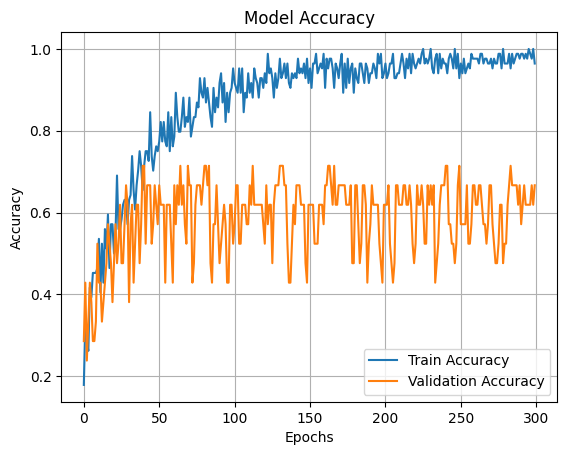

In [33]:
# ✅ Step 6: Evaluate the Model
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()